## **Image Matching in SQL with SingleStoreDB**

In this example, we’ll demonstrate how we use the dot_product function (for cosine similarity) to find a matching image of a celebrity from among 7000 records in just 3 milliseconds! 

Vector functions in SingleStoreDB make it possible to solve AI problems, including face matching, product photo matching, object recognition, text similarity matching and sentiment analysis.

This notebook is stored in our [SingleStoreLab's github repository](https://github.com/singlestore-labs/singlestoredb-samples/tree/main/Tutorials/Face%20matching) .

**Step 1**: Signup for a free trial account at https://portal.singlestore.com/ 

**Step 2**: Create a workspace (S00 is enough). 

**Step 3**: Create a database called image_recognition in the SQL Editor

`Create database image_recognition;`

**Step 4**: Go to ‘connect’ on your workspace in the portal and copy the workspace URL, your username and password to connect to your database using sqlalchemy. 
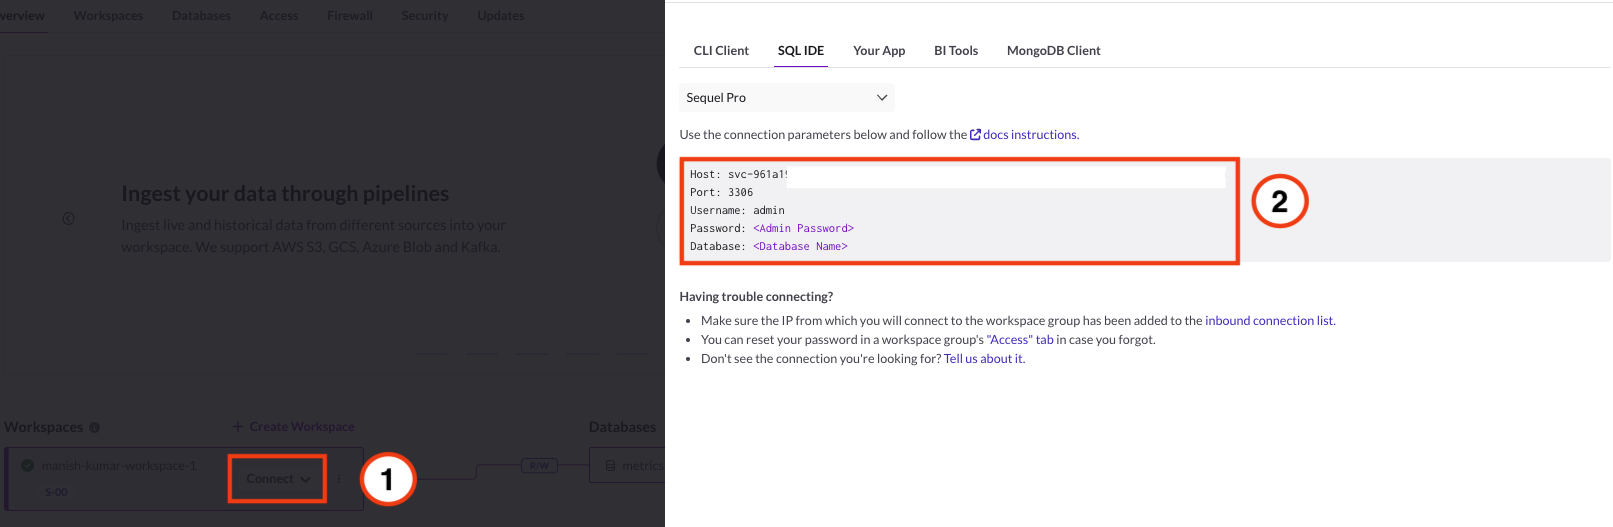


**Step 5**: Import the the following libraries into your python kernel or Jupyter notebook

In [ ]:
!pip3 install sqlalchemy pymysql boto3
from sqlalchemy import *
import pymysql, boto3, requests, json
import matplotlib.pyplot as plt
import ipywidgets as widgets
from botocore import UNSIGNED
from botocore.client import Config

**Step 6**: Create the connection string

In [3]:
UserName='<Username usually admin>'
Password='<Password for that user>'
DatabaseName='image_recognition'
URL='<Host that you copied above>:3306'
db_connection_str = "mysql+pymysql://"+UserName+":"+Password+"@"+URL+"/"+DatabaseName
db_connection = create_engine(db_connection_str)

**Step 7**: Create a table, named people, in your database.

In [ ]:
query = 'create table people (filename varchar(255), vector blob, shard(filename))'
db_connection.execute(query)

**Step 8**: Import our sample dataset into your database. Alternatively follow the instructions in our blog to learn how you can create your vectors for your own images using facet and insert them into SingleStoreDB

In [ ]:
url = 'https://raw.githubusercontent.com/singlestore-labs/singlestoredb-samples/main/Tutorials/Face%20matching/celebrity_data.sql'
response = requests.get(url)
sql_script = response.text
new_array = sql_script.split('\n')
for i in new_array:
 if (i != ''):
  db_connection.execute(i)

**Step 9**: Run our image matching algorithm using just 2 lines of SQL. In this example, we use Adam Sandler:


In [ ]:
selected_name = "Adam_Sandler/Adam_Sandler_0003.jpg"
query1 = 'set @v = (select vector from people where filename = "' + selected_name + '");'
query2 = 'select filename, dot_product(vector, @v) as score from people order by score desc limit ' + str(num_matches) +';'
db_connection.execute(query1)
result = db_connection.execute(query2)
for res in result:
 print(res)

**(Optional) Step 10**: Use our visualizer and drop down to see this image matching in action!

In [4]:
s3 = boto3.resource('s3',region_name='us-east-1', config=Config(signature_version=UNSIGNED))
bucket = s3.Bucket('studiotutorials')
prefix = 'face_matching/'
names=[]
for obj in bucket.objects.all():
 if (obj.key.startswith(prefix)):
  drop = obj.key[len(prefix):]
  names.append(drop)
def on_value_change(change):
  selected_name = change.new
  print(selected_name)
  num_matches = 5
  #SingleStore query to find the vectors of images that match
  query1 = 'set @v = (select vector from people where filename = "' + selected_name + '");'
  query2 = 'select filename, dot_product(vector, @v) as score from people order by score desc limit ' + str(num_matches) +';'
  db_connection.execute(query1)
  result = db_connection.execute(query2)
  original = "/original.jpg"
  bucket.download_file(prefix + selected_name, original)
  images = []
  matches = []
  cnt = 0
  images.append(original)
  for res in result:
   print(res)
   temp_file = "/match" + str(cnt) + ".jpg"
   bucket.download_file(prefix + res[0], temp_file)
   images.append(temp_file)
   matches.append(res[1])
   cnt += 1
  fig, axes = plt.subplots(nrows=1, ncols=num_matches+1, figsize=(40, 40))
  for i in range(num_matches+1):
   axes[i].imshow(plt.imread(images[i]))
   axes[i].set_xticks([])
   axes[i].set_yticks([])
   axes[i].set_xlabel('')
   axes[i].set_ylabel('')
   if i == 0:
    axes[i].set_title("Original Image", fontsize=14)
   else:
    axes[i].set_title("Match " + str(i) + ". Score: " + str(matches[i-1]), fontsize=14)
  plt.show()
dropdown = widgets.Dropdown(
  options=names,
  description='Select an Image:',
  value=names[0]
)
dropdown.observe(on_value_change, names='value')
display(dropdown)